In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
from mlelec.data.dataset import QMDataset
from mlelec.utils.target_utils import get_targets
from mlelec.features.acdc import compute_features
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
import matplotlib.pyplot as plt

In [27]:
from mlelec.models.linear import LinearModelPeriodic
from metatensor.torch import TensorMap, Labels, TensorBlock
from mlelec.metrics import L2_loss

In [3]:
frame = ase.Atoms("C6H6")
rc = 1.384
rh = 2.465
for i in range(6):
    frame.positions[i] = [np.cos(i*np.pi/3)*rc,np.sin(i*np.pi/3)*rc,0]
    frame.positions[i+6] = [np.cos(i*np.pi/3)*rh,np.sin(i*np.pi/3)*rh,0]

In [4]:
np.random.seed(321)
torch.random.manual_seed(321)
fock = np.random.uniform(size=(30,30))
fock = fock+fock.T
ref_eva = np.linalg.eigvalsh(fock)

In [5]:
device = 'cpu'
orbitals = {'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
            'benzene_inv': {6: [[2,0,0],[3,0,0], [4,0,0],[5,0,0]], 1:[[1,0,0]]},
            }
max_radial  = 12
max_angular = 8
atomic_gaussian_width = 0.3
cutoff = 6
LCUT = 3

In [6]:
dataset = QMDataset(frames = [frame], 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=[fock],
                   device = device, 
                   orbs = orbitals['benzene'], 
                   orbs_name = None
                   )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [7]:
target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [8]:
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

In [9]:
hfeat = compute_features(dataset, hypers_atom, LCUT, hypers_pair = hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [10]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    return loss, pred, ridges, block_losses

In [11]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, 
                                  orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                        )
print(loss_ridge_bias)

tensor(534.1980)


In [12]:
ld = np.linspace(-0.1,0.1,31)
frames_displace = []
fockdummy = []
for i,d in enumerate(ld):
    fd = frame.copy()    
    cent = fd.positions.mean(axis=0)
    fd.positions -= cent
    fd.positions[[-5,-2]] *= 1+d
    fd.positions[[-6,-3]] *= 1-d
    fd.positions += cent
    frames_displace.append(fd)
    fockdummy.append(np.zeros_like(fock))
    
dataset_displaced = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=False,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = orbitals['benzene'], 
                              orbs_name = None
                              )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [13]:
hfeat_d = compute_features(dataset_displaced, hypers_atom, LCUT, hypers_pair=hypers_pair)

cpu pair features
cpu single center features
cpu single center features


In [14]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:866: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [15]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp = [f[0,0,0].numpy() for f in fockd]

In [16]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

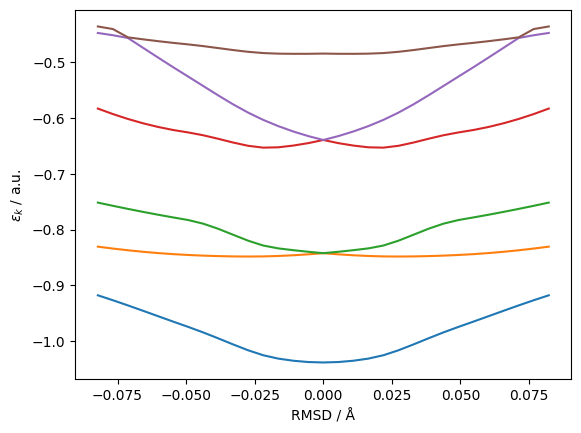

In [17]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
# plt.savefig("../figures/benzene-deformations.svg")

## Invariant H

In [18]:
dataset_inv = QMDataset(frames = [frame], 
                   kmesh = [1,1,1], 
                   fix_p_orbital_order=True,
                   dimension = 0,
                   fock_realspace=[fock],
                   device = device, 
                   orbs = orbitals['benzene_inv'], 
                   orbs_name = None
                   )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [24]:
dataset_displaced_inv = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=False,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = orbitals['benzene_inv'], 
                              orbs_name = None
                              )

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/data/dataset.py:908: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [19]:
target_coupled_blocks_inv = get_targets(dataset_inv, cutoff = cutoff, device = device)

In [20]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_inv,
                                  frames = dataset.structures, 
                                  orbitals = dataset_inv.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_inv,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-10, -1, 100),
                                                                        )
print(loss_ridge_bias)

tensor(82.1192)


In [21]:
fock_pred  = next(iter(blocks_to_matrix(pred_ridge_bias, dataset_inv)[0].values()))

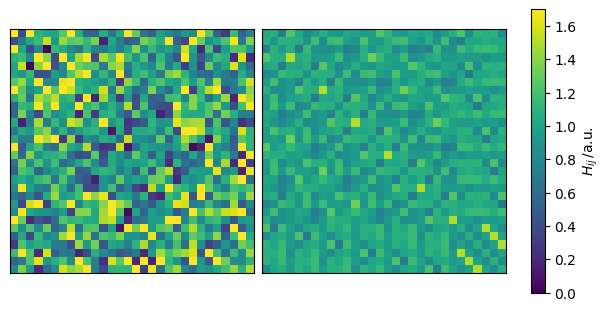

In [22]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(fock_pred, vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

1.477862714373585
0.016273980152756308
0.11758709927229476


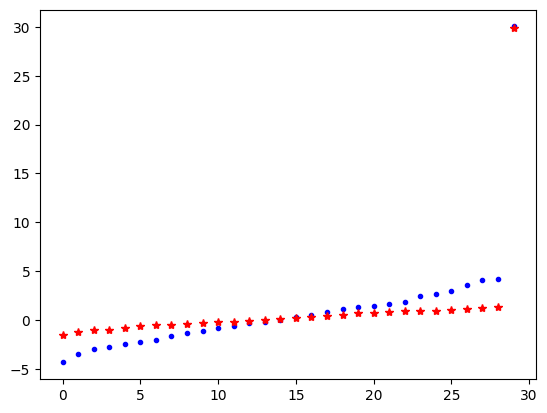

In [23]:
eva_ref = np.linalg.eigvalsh(fock)
eva_pred = np.linalg.eigvalsh(fock_pred)
plt.plot(eva_ref, 'b.')
plt.plot(eva_pred, 'r*') 
print(np.sqrt(np.mean((np.linalg.eigvalsh(fock)-np.linalg.eigvalsh(fock_pred))**2)))
print(np.linalg.eigvalsh(fock)[14])
print(np.linalg.eigvalsh(fock_pred)[14])

In [27]:
pred_disp = model_ridge.predict_ridge_analytical(ridges = ridges_bias, hfeat=hfeat_d)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:866: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [28]:
fockd = blocks_to_matrix(pred_disp, dataset_displaced_inv)
fock_disp = [f[0,0,0].numpy() for f in fockd]

In [29]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

Text(0.5, 1.0, 'invariant')

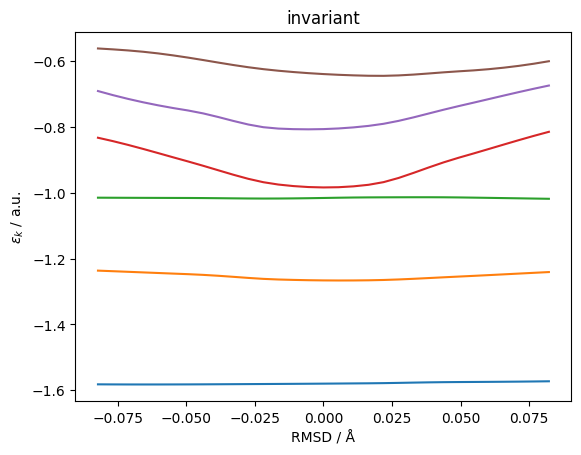

In [30]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")
plt.title('invariant')
# plt.savefig("../figures/benzene-deformations.svg")

# TORCH

In [25]:
# from mlelec.models.linear_integrated import LinearModelPeriodic


In [26]:
# target_keynames = target_coupled_blocks.keys.names
# keys = []
# blocks= []
# for k,b in target_coupled_blocks.items(): 
#     li, lj, L = k['l_i'], k['l_j'], k['L']
#     inversion_sigma = (-1) ** (li + lj + L)
#     keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
#     blocks.append(b.copy())
# target_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
# target_coupled_blocks_copy = target_coupled_blocks.copy()
# target_coupled_blocks = target_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

### Train matrix

In [27]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [28]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [29]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(1001):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    
    loss = L2_loss(target_coupled_blocks, pred)
    # loss = L2_loss(target_k, predk)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 761.1750823051082
100 536.952637808095
200 534.006510561811
300 534.0064993211787
400 534.0064598065721
500 534.0064598045009
600 534.0064694744127
700 534.0064598123606
800 534.006459804501
900 534.0064598045009
1000 534.0064598045009


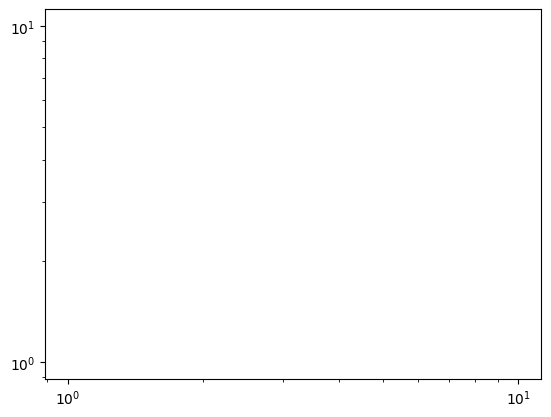

In [30]:
plt.loglog(test_losses)

### Train eigvals

This training should not make a zero error, as the prediction will always have the degeneracy compatible with the characters of the eigstates whereas the randomly generated reference will not, so the model will approximate the two and not be able to learn the spectrum perfectly even for one structure 

In [31]:
def eigval_loss(pred, target):
    eva_pred = torch.linalg.eigvalsh(pred)
    eva_target = torch.linalg.eigvalsh(target)
    assert eva_pred.shape == eva_target.shape
    return torch.sum(eva_pred-eva_target)**2

In [32]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [33]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [34]:
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset.fock_realspace[0]))

In [35]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(501):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 933.7042503844553
100 0.5444957897110183
200 0.44519536161048756
300 0.4451935350349099
400 0.44519353498296027
500 0.4451935349829579


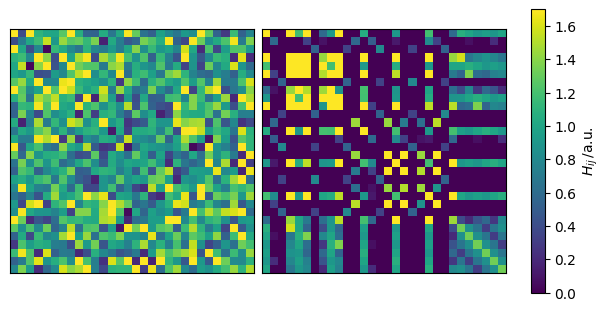

In [36]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy(), vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

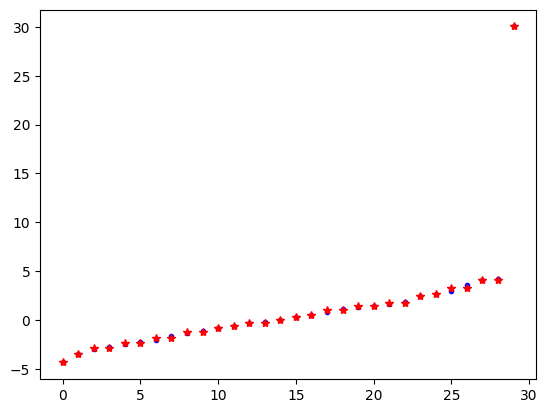

In [37]:
plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

plt.plot(pred_eigvals, 'r*')

In [38]:
pred_disp = model.predict(features=hfeat_d)
fockd = blocks_to_matrix(pred_disp, dataset_displaced)
fock_disp = [f[0,0,0].detach().numpy() for f in fockd]

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:615: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


In [39]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction still maintains the compatibility with the Jahn-Teller effect as we still model an intermediate H

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

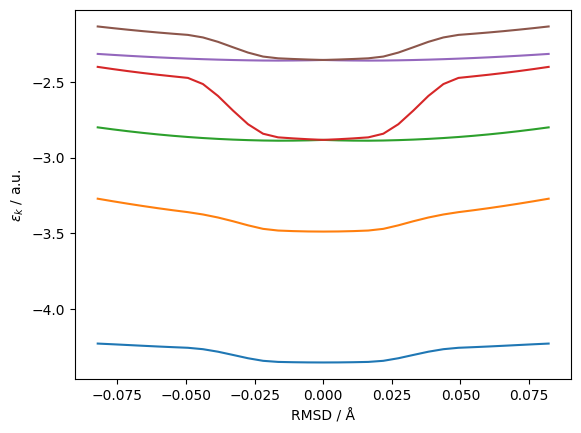

In [40]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

## Invariant intermediate H

we are able to make a much smaller error here than in the previous case 

In [17]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks_inv,
                            frames = dataset_inv.structures, orbitals = dataset_inv.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

NameError: name 'target_coupled_blocks_inv' is not defined

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [ ]:
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset_inv.fock_realspace[0]))

In [45]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(501):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals)
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 0.009748584409848238
100 0.004856242060539429
200 0.002667541245488818
300 0.000980273210746498
400 0.0003085040887802308
500 0.00011894658125337124


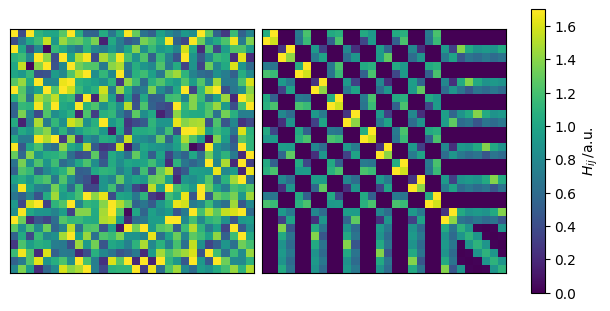

In [105]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy(), vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

In [104]:
pred = model()
reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
print("Error in H, " , L2_loss(reconmat, torch.from_numpy(fock)))
print(r"Error in $\epsilon$, ", L2_loss(target_eigvals, torch.linalg.eigvalsh(reconmat)))

Error in H,  tensor(2265.0976, grad_fn=<PowBackward0>)
Error in $\epsilon$,  tensor(0.0002, grad_fn=<PowBackward0>)


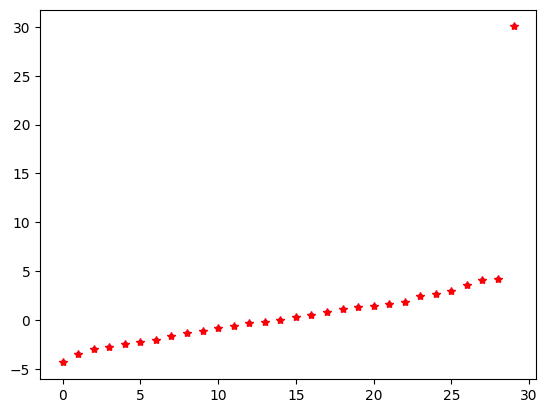

In [94]:
plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset_inv)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

plt.plot(pred_eigvals, 'r*')

In [89]:
pred_disp_inv = model.predict(features=hfeat_d)
fockd_inv = blocks_to_matrix(pred_disp_inv, dataset_displaced_inv)
fock_disp_inv = [f[0,0,0].detach().numpy() for f in fockd_inv]

In [90]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp_inv]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction, as expected, cannot maintain the compatibility with the Jahn-Teller effect as the intermediate invairant H loses all symmetries

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

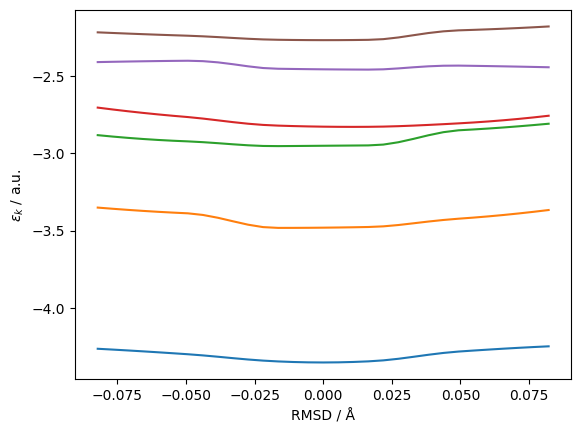

In [91]:
for k in range(0,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

## Learn a smaller invariant basis

### Model first 12 states 

In [84]:
fockdummy = []
for i,d in enumerate(ld):
    # fockdummy.append(torch.zeros(12,12))
    fockdummy.append(torch.zeros(18,18))

In [132]:
dataset_smallbasis = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=True,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = {6: [[2,0,0]#, [3,0,0]],
                                           1:[[1,0,0]]}, 
                              orbs_name = None
                              )
target_coupled_blocks = get_targets(dataset_smallbasis, cutoff = cutoff, device = device)

KeyError: 6

In [121]:
dataset_displaced_smallbasis = QMDataset(frames = frames_displace, 
                              kmesh = [1,1,1], 
                              fix_p_orbital_order=True,
                              dimension = 0,
                              fock_realspace=fockdummy,
                              device = device, 
                              orbs = dataset_smallbasis.basis, 
                              orbs_name = None
                              )


In [122]:
model =  LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset_smallbasis.structures, orbitals = dataset_smallbasis.basis, 
                            device = device,
                            bias = True, #True
                            nhidden = 16, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )

In [123]:
model.model.keys()

odict_keys(['(0, 1, 1, 0, 1, 1, 0, 0)', '(0, 6, 2, 0, 6, 2, 0, 0)', '(1, 1, 1, 0, 1, 1, 0, 0)', '(1, 6, 2, 0, 6, 2, 0, 0)', '(2, 1, 1, 0, 6, 2, 0, 0)'])

In [124]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
eval_every = 100

In [125]:
# target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(fock))[:12] 
target_eigvals = torch.linalg.eigvalsh(torch.from_numpy(dataset.fock_realspace[0]))[:len(fockdummy[0])]#[1:12]

In [126]:
losses = []
test_losses = []
BEST = 1e13
for epoch in range(501):
    
    optim.zero_grad()
    
    pred = model()
    # predk = TMap_bloch_sums(pred, phase)
    reconmat = next(iter(blocks_to_matrix(pred, dataset_smallbasis)[0].values()))
    pred_eigvals = torch.linalg.eigvalsh(reconmat)
    # loss = eigval_loss(fock , reconmat)
    loss = L2_loss(target_eigvals, pred_eigvals[:])#[1:12]
    
    loss.backward()
    losses.append(loss.item())
    
    optim.step()    

    if epoch%eval_every ==0:
        # model.train= False
        # test_pred = model.predict(hfeat_test, test_coupled_blocks)
        # test_loss = L2_loss(test_pred, test_coupled_blocks)
        # test_losses.append(test_loss.item())
        # # print(epoch, test_loss.item())
        
        # if test_loss<BEST:
        #     # print('new_best')
        #     BEST = test_loss
        #     checkpoint = {'model_statedict':model.state_dict, 
        #                   'optimizer_statedict':optim.state_dict,
        #                   'train loss':loss,
        #                   'test_loss': test_loss,
        #                   'pred': model()
        #                  }
        #     # torch.save(checkpoint, 'checkpoint_2.pt')
        # model.train = True
    # if epoch%100 == 0 :
        print(epoch, loss.item())#, test_loss.item()) #, L2_loss(target_coupled_blocks, pred).item())
        

0 56.16583508505457
100 0.4248180884667329
200 0.4246399774188525
300 0.424639966960121
400 0.42463996695987055
500 0.4246399669598701


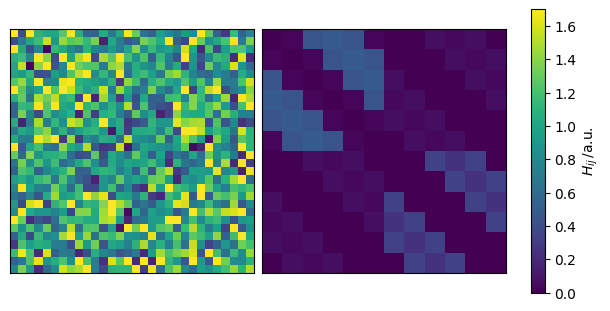

In [127]:
fig, ax = plt.subplots(1,2,figsize=(6,3), constrained_layout=True)
ax[0].matshow(fock, vmin=0, vmax=1.7, interpolation='None')
ms = ax[1].matshow(reconmat.detach().numpy(), vmin=0, vmax=1.7, interpolation='None')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
fig.colorbar(ms, ax=ax.ravel().tolist(), label=r"$H_{ij}\,/$a.u.")

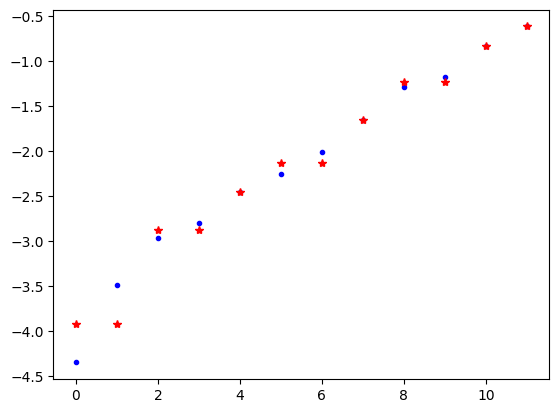

In [128]:
plt.plot(target_eigvals, 'b.')
pred = model()
    # predk = TMap_bloch_sums(pred, phase)
reconmat = next(iter(blocks_to_matrix(pred, dataset_smallbasis)[0].values()))
pred_eigvals = torch.linalg.eigvalsh(reconmat.detach())

# plt.plot(pred_eigvals[1:12], 'r*')
plt.plot(pred_eigvals, 'r*')

In [129]:
pred_disp_inv = model.predict(features=hfeat_d)
fockd_inv = blocks_to_matrix(pred_disp_inv, dataset_displaced_smallbasis)
fock_disp_inv = [f[0,0,0].detach().numpy() for f in fockd_inv]

In [130]:
evd = [np.linalg.eigvalsh(f) for f in fock_disp_inv]
dd = np.asarray([np.sqrt(((frames_displace[i].positions-frames_displace[len(frames_displace)//2].positions)**2).mean())*np.sign(ld[i]) for i in range(len(frames_displace)) ])

The prediction, as expected, cannot maintain the compatibility with the Jahn-Teller effect as the intermediate invairant H loses all symmetries

Text(0, 0.5, '$\\epsilon_k$ / a.u.')

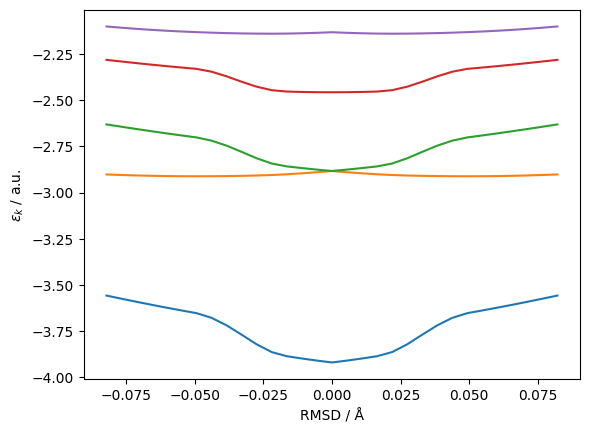

In [131]:
for k in range(1,6):
    plt.plot(dd, [ev[k] for ev in evd], '-')   
plt.xlabel("RMSD / Å")
plt.ylabel(r"$\epsilon_k$ / a.u.")

### Model any 4 random states